# Inspect data and add geometry

This is the most important step of all, since a bad geometry will invalidate every subsequent processing steps.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import rsf.api as sf

%matplotlib inline

# Set a custom DATAPATH to Madagascar
%env DATAPATH=/home/rodrigo/Projetos/Viking/DATAPATH/

env: DATAPATH=/home/rodrigo/Projetos/Viking/DATAPATH/


In [2]:
sns.set_style('ticks')

In [3]:
raw_data = 'seismic.segy'

## Read a data sample of 200 traces

In [4]:
data_sample = 'sample_agc.rsf'

!sfsegyread n2=200 read=d < {raw_data} | sfagc > {data_sample}

get the format
format=0
test su
get format from bhead
switch format=1


In [5]:
!sfin {data_sample}

sample_agc.rsf:
    in="/home/rodrigo/Projetos/Viking/DATAPATH/sample_agc.rsf@"
    esize=4 type=float form=native 
    n1=1500        d1=0.004       o1=0          label1="Time" unit1="s" 
    n2=200         d2=1           o2=0          label2="Trace" 
	300000 elements 1200000 bytes


In [6]:
data_sample = sf.Input(data_sample)

In [7]:
n1 = data_sample.int('n1')
n2 = data_sample.int('n2')
d1 = data_sample.float('d1')
o1 = data_sample.float('o1')

In [8]:
data = np.zeros((n2, n1), dtype=np.float32)

In [9]:
data_sample.read(data)

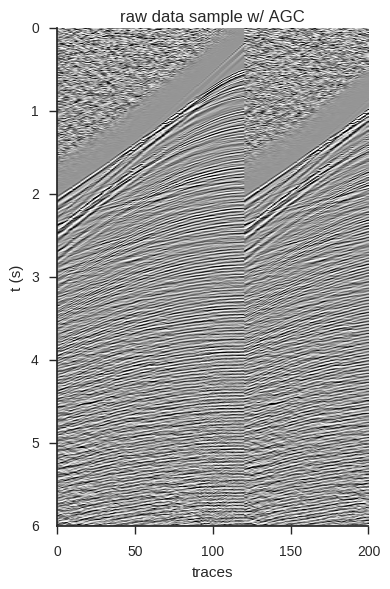

In [10]:
perc = np.percentile(data.ravel(), 99)
t = np.arange(n1) * d1 + o1
extent = [0, n2, t[-1], o1]
plt.figure(figsize=(4, 6))
plt.imshow(data.clip(-perc, perc).T, aspect='auto', extent=extent)

plt.ylabel('t (s)')
plt.xlabel('traces')

plt.title('raw data sample w/ AGC')

sns.despine()

plt.tight_layout()

We can see the data above really well, every shot seem to be around 120 traces long. We also see coherent events, so we know that our data file is not corrupted.

## Inspect all the header and text headers

In [11]:
header_raw = 'line_12_header_raw.rsf'
text_header = 'line_12_text_header.txt'

!sfsegyread read=h < {raw_data} tfile={header_raw} hfile={text_header} > /dev/null

get the format
format=0
test su
get format from bhead
switch format=1


In [12]:
!cat {text_header} | fold -w 80

C 1 CLIENT                        COMPANY                       CREW NO         
C 2 LINE            AREA                        MAP ID                          
C 3 REEL NO           DAY-START OF REEL     YEAR      OBSERVER                  
C 4 INSTRUMENT: MFG            MODEL            SERIAL NO                       
C 5 DATA TRACES/RECORD        AUXILIARY TRACES/RECORD         CDP FOLD          
C 6 SAMPLE INTERNAL         SAMPLES/TRACE       BITS/IN      BYTES/SAMPLE       
C 7 RECORDING FORMAT        FORMAT THIS REEL        MEASUREMENT SYSTEM          
C 8 SAMPLE CODE: FLOATING PT     FIXED PT     FIXED PT-GAIN     CORRELATED      
C 9 GAIN  TYPE: FIXED     BINARY     FLOATING POINT     OTHER                   
C10 FILTERS: ALIAS     HZ  NOTCH     HZ  BAND    -     HZ  SLOPE    -    DB/OCT 
C11 SOURCE: TYPE            NUMBER/POINT        POINT INTERVAL                  
C12     PATTERN:                           LENGTH        WIDTH                  
C13 SWEEP: START     HZ  END

In [13]:
!sfheaderattr < {header_raw}

91 headers, 120120 traces
******************************************************************************* 
     key     	            min     	              max    	          mean
------------------------------------------------------------------------------- 
tracl       0              1 @ 0	        120120 @ 120119	       60060.5
tracr       1              1 @ 0	        120120 @ 120119	       60060.5
fldr        2              3 @ 0	          1003 @ 120000	           503
tracf       3              1 @ 0	           120 @ 119	          60.5
ep          4            101 @ 0	          1112 @ 120000	       608.012
cdp         5              1 @ 0	          2142 @ 120119	       1074.52
cdpt        6              1 @ 0	           120 @ 119	          60.5
trid        7              1 @ 0	             1 @ 0	             1
nhs         9              1 @ 0	             1 @ 0	             1
offset     11          -3237 @ 0	          -262 @ 119	       -1749.5
gelev      12            -10 @ 0	      

As I suspected, we have 120 traces per shot (tracf), also the geometry seem to be fairly complete, with cdp, shotpoint and offset all set. The text header does not provide us with any additional information.

In [14]:
# We need to convert the header to floating point before reading with python
header_float = 'line_12_header_float.rsf'

!sfdd type=float < {header_raw} > {header_float}

In [15]:
header = sf.Input(header_float)

In [16]:
n1 = header.int('n1')
n2 = header.int('n2')

In [17]:
data = np.zeros((n2, n1), dtype=np.float32)

In [18]:
header.read(data)

In [19]:
import pandas as pd

In [20]:
# Iterate over file w/ SEG-Y keyword/index relation
keys = {}

for index, row in pd.read_csv('keys.txt', sep=' ').iterrows():
    keys[row.key] = row.id

Now lets create a DataFrame with the line header. Pandas DataFrames are easier to manipulate.

In [21]:
header = pd.DataFrame()

for k in keys:
    header[k] = data[:,keys[k]]
    
header[['offset', 'ep', 'cdp', 'sx', 'gx']].head()

,offset,ep,cdp,sx,gx
0,-3237,101,1,3237,0
1,-3212,101,2,3237,25
2,-3187,101,3,3237,50
3,-3162,101,4,3237,75
4,-3137,101,5,3237,100


### Investigating the line geometry with some QC plots

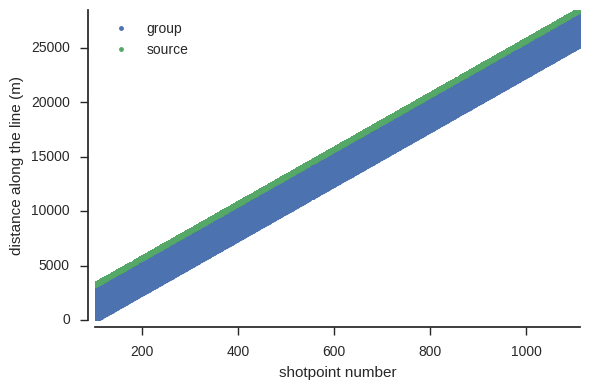

In [22]:
plt.plot(header.ep, header.gx, '.', label='group')
plt.plot(header.ep, header.sx, '.', label='source')


plt.legend(loc='upper left')

plt.xlabel('shotpoint number')
plt.ylabel('distance along the line (m)')

plt.axis('tight')
sns.despine(offset=5)
plt.tight_layout()

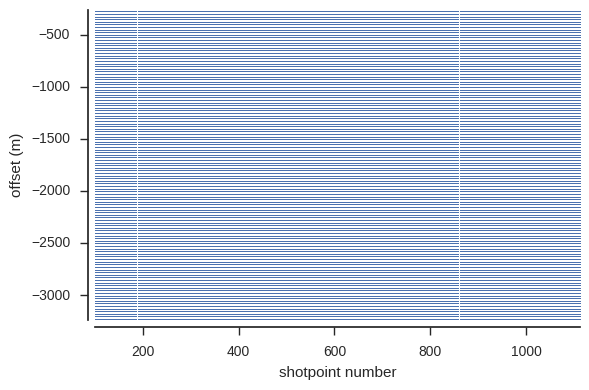

In [23]:
plt.plot(header.ep, header.offset, ',')

plt.xlabel('shotpoint number')
plt.ylabel('offset (m)')

plt.axis('tight')
sns.despine(offset=5)
plt.tight_layout()

To properly manipulate the line geometry we need some extra keywords, like sequential shotpoint, proper cdpt, group number and trace number with group ensemble.

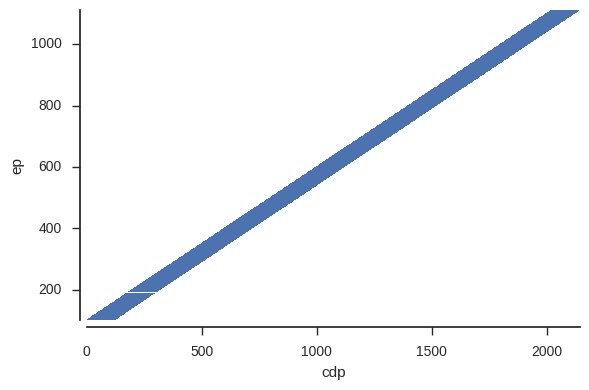

In [24]:
plt.plot(header.cdp, header.ep, ',')


plt.xlabel('cdp')
plt.ylabel('ep')

plt.axis('tight')
sns.despine(offset=5)
plt.tight_layout()

### Recovering the original group number

This survey is stack array, since 262 m/25 m ~ 10.5, so we can recover the group number with the following expression

In [25]:
header['grnofr'] = header.ep - 10.5 - np.abs(header.tracf - 120)

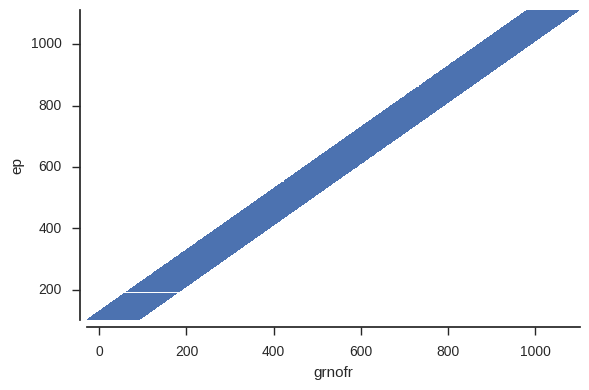

In [26]:
plt.plot(header.grnofr, header.ep, ',')

plt.xlabel('grnofr')
plt.ylabel('ep')

plt.axis('tight')
sns.despine(offset=5)
plt.tight_layout()

In [27]:
offset = (header['ep'] - header['grnofr'])  * 25
# 0.5 m is the difference between the real minimum offset and
# the offset to make this survey a perfect stack array
offset -= 0.5
# Also, all offsets are negative
offset = -offset

# Lets check if the provided offset and calculated offset matches
np.allclose(offset, header['offset'])

True

In [28]:
# Lets check if the sequential CDP provided and our
# calculated CDP matches

cdp = (header.ep + header.grnofr)/2
bins = cdp.unique()
np.allclose(header.cdp, np.digitize(cdp, bins))

True

In [29]:
# Now lets create a sequential group number for sorting purposes
bins = header.grnofr.unique()
header['grnors'] = np.digitize(header.grnofr, bins)

In [30]:
# We also need a equivalent to CDPT for for common group sorting

header['offset_bin'] = header.grnofr - header.ep
header['grnlof'] = header.groupby('grnors').offset_bin.apply(np.argsort)

In [31]:
# Since there is skips, we also need a sequential shotpoint
# lets recicle the fldr keyword
bins = header.ep.unique()
fldr = np.digitize(header.ep, bins)
header['fldr'] = fldr

## Recalculate a proper CDPT

The original CDPT has skips on it, we need a truly sequential CDPT, otherwise the data in CDP domain will be filled with many zeroed traces.

In [32]:
header['cdpt'] = header.groupby('cdp').offset_bin.apply(np.argsort)
header.drop('offset_bin', axis=1, inplace=True)

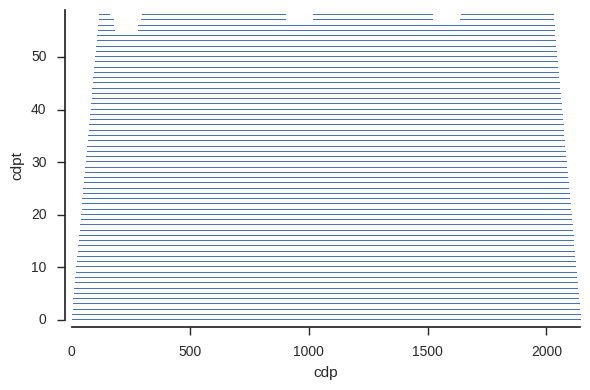

In [33]:
plt.plot(header.cdp, header.cdpt, ',')


plt.xlabel('cdp')
plt.ylabel('cdpt')

plt.axis('tight')
sns.despine(offset=5)
plt.tight_layout()

## Geometry summary

With the keywords listed below properly set we can sort the data to any domain we want (i.e. Common Mid Point Gather, Common Shotpoint Gather, Common Receiver Group Gather).

| keyword | usage |
|------|------|
| fldr | sequential shotpoint |
| ep | field shotpoint |
| tracf | trace number within common shot ensemble |
| cdp | sequential common mid point number |
| cdpt | trace number within common mid point ensemble |
| grnofr | field receiver group number |
| grnors | sequential receiver group number |
| grnlof | trace number within common receiver group ensemble |

Now, all we need to do is write a RSF file with the improved header and also read all trace data. Also, there is no need to resample the data, since its already in 4 ms sampling rate.

In [34]:
for k in keys:
    data[:,keys[k]] = header[k].values

header_complete = 'line_12_header_complete.rsf'

out = sf.Output(header_complete)
out.put('n1', n1)
out.put('n2', n2)

out.write(data)
out.close()

In [35]:
!sfin {header_complete}

line_12_header_complete.rsf:
    in="/home/rodrigo/Projetos/Viking/DATAPATH/line_12_header_complete.rsf@"
    esize=4 type=float form=native 
    n1=91          d1=?           o1=?          
    n2=120120      d2=?           o2=?          
	10930920 elements 43723680 bytes


In [36]:
# Now we just need to convert to int since Madagascar's sorting programs
# only work with integer headers
header_int = 'line_12_header_int.rsf'

!sfdd type=int < {header_complete} > {header_int}

# Convert full trace data to RSF format

In [37]:
common_shot = 'line_12_csg_raw.rsf'

!sfsegyread read=d < {raw_data} | sfput n2=120 n3=1001 > {common_shot}

get the format
format=0
test su
get format from bhead
switch format=1


In [38]:
!sfin {common_shot}

line_12_csg_raw.rsf:
    in="/home/rodrigo/Projetos/Viking/DATAPATH/line_12_csg_raw.rsf@"
    esize=4 type=float form=native 
    n1=1500        d1=0.004       o1=0          label1="Time" unit1="s" 
    n2=120         d2=1           o2=0          label2="Trace" 
    n3=1001        d3=?           o3=?          
	180180000 elements 720720000 bytes
